# ML Case Study
### **Covid Detection using CT Scan Images**


---

By

name and rn

In [ ]:
import os
import gc
import cv2
import math
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, roc_curve
from keras.layers import GlobalAveragePooling2D
from keras.applications.densenet import DenseNet201

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.7.0


## Kaggle Configurations

In [2]:
#Downloading from kaggle
!pip install kaggle

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading Dataset from kaggle and unzipping it


In [ ]:
!kaggle datasets download plameneduardo/sarscov2-ctscan-dataset

In [5]:
!unzip /content/sarscov2-ctscan-dataset.zip

Archive:  /content/sarscov2-ctscan-dataset.zip
  inflating: COVID/Covid (1).png     
  inflating: COVID/Covid (10).png    
  inflating: COVID/Covid (100).png   
  inflating: COVID/Covid (1000).png  
  inflating: COVID/Covid (1001).png  
  inflating: COVID/Covid (1002).png  
  inflating: COVID/Covid (1003).png  
  inflating: COVID/Covid (1004).png  
  inflating: COVID/Covid (1005).png  
  inflating: COVID/Covid (1006).png  
  inflating: COVID/Covid (1007).png  
  inflating: COVID/Covid (1008).png  
  inflating: COVID/Covid (1009).png  
  inflating: COVID/Covid (101).png   
  inflating: COVID/Covid (1010).png  
  inflating: COVID/Covid (1011).png  
  inflating: COVID/Covid (1012).png  
  inflating: COVID/Covid (1013).png  
  inflating: COVID/Covid (1014).png  
  inflating: COVID/Covid (1015).png  
  inflating: COVID/Covid (1016).png  
  inflating: COVID/Covid (1017).png  
  inflating: COVID/Covid (1018).png  
  inflating: COVID/Covid (1019).png  
  inflating: COVID/Covid (102).png   
  i

## Reading the dataset

In [8]:
categories=['COVID', 'non-COVID']
data_dir = "C:\\Users\\VeeaaR\\Desktop\\NNDL\\New folder"
train_dir = os.path.join(data_dir)

Storing the filenames along with their categories into a dataframe

In [9]:
train_data=[]

train_data = []
for defects_id, sp in enumerate(categories):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [10]:
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (7).png,0,COVID
1,COVID/Covid (327).png,0,COVID
2,COVID/Covid (232).png,0,COVID
3,COVID/Covid (204).png,0,COVID
4,COVID/Covid (57).png,0,COVID


In [12]:
train.to_csv( 'train.csv')

Function to read and resize every image file

In [ ]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [ ]:
IMAGE_SIZE = 64
X = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in tqdm(enumerate(train['File'].values), total = len(train)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

Normalizing the pixel values and converting them between the range of 0-1

In [ ]:
X /= 255.
y = train['DiseaseID'].values
print(X.shape)
print(y.shape)

(2481, 64, 64, 3)
(2481,)


## Visualizing the images

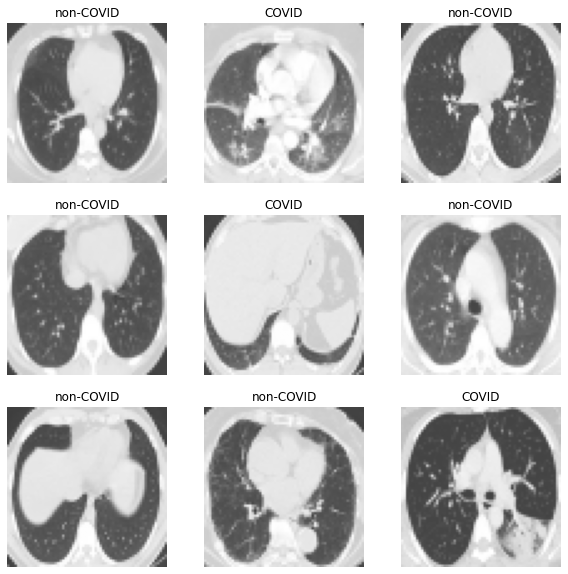

In [ ]:
plt.figure(figsize=(10, 10))
idx = np.random.randint(0, X.shape[0], (9))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X[idx[i]])
  plt.title(categories[y[idx[i]]])
  plt.axis("off")

## KMeans Clustering
- The raw data does not contain patient ID.
- So multiple images can come from the same patient.
- So before splitting the train and validation sets, we should make sure that the same patient's image does not go into boh sets.
- This prevents data leakage.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
X0 = X[y == 0].reshape(len(X[y==0]), -1)
X1 = X[y == 1].reshape(len(X[y==1]), -1)

In [ ]:
k = 60
kmeans = KMeans(k)

cluster0 = kmeans.fit_predict(X0)
cluster1 = kmeans.fit_predict(X1)

In [ ]:
#Since both cluster0 and cluster1 are between 0-59
cluster1 += k

In [ ]:
cluster = np.concatenate([cluster0, cluster1])

Visualizing the clusters

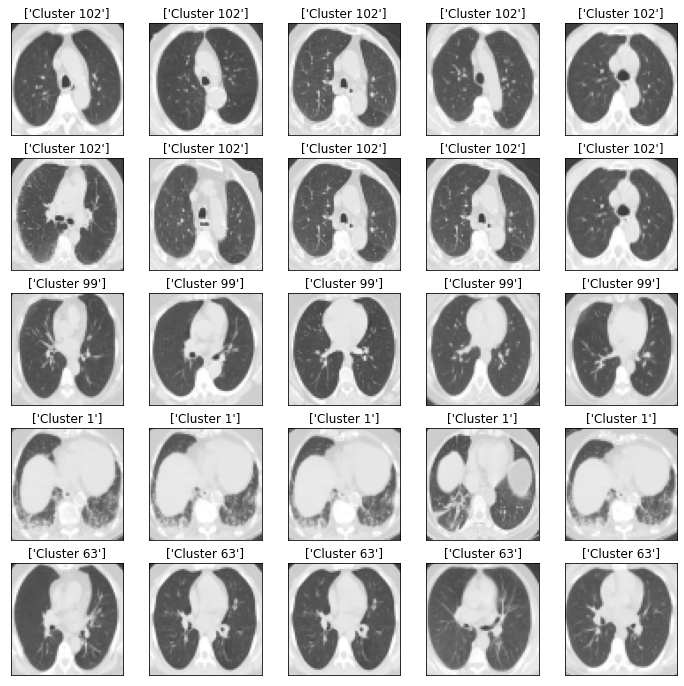

In [ ]:
np.random.seed(42)

rows = 5 
cols = 5

fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
for i in range(rows):
    clt = np.random.randint(0, 2 * k)
    clt_idx = np.random.choice(np.where(cluster == clt)[0], cols, replace = True)
    X_clt = X[clt_idx]
    for j in range(cols):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title([f'Cluster {clt}'])
        ax[i, j].imshow(X_clt[j])

### Inference
- The images from the same cluster are very similar to each other.
- Most likely these images could be of a same patient.
- So we should ensure that images from the same cluster do not go into both train and test sets.

## Create training and test sets

In [ ]:
train_idx, test_idx = next(GroupShuffleSplit(test_size = 0.2, 
                                            n_splits = 2, 
                                            random_state = 42).split(X, groups = cluster))

In [ ]:
X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]

## Model Building

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score

In [ ]:
def reshapeInputs(X):
  return X.reshape(X.shape[0], -1)

In [ ]:
def plotConfusionMatrix(y_org, y_pred):
  cm = confusion_matrix(y_org, y_pred)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

In [ ]:
def crossValEvaluate(model, X, y):
  y_pred = cross_val_predict(model, reshapeInputs(X), y, cv=3);
  
  scores = accuracy_score(y_pred, y)
  print(f'Validation Accuracy: {scores}')

  plotConfusionMatrix(y, y_pred)

  print(f'Precision: {precision_score(y, y_pred)}')
  print(f'Recall: {recall_score(y, y_pred)}')

In [ ]:
def testSetEvaluate(model, X_train, y_train, X_test, y_test):
  model.fit(reshapeInputs(X_train), y_train)
  y_pred = model.predict(reshapeInputs(X_test))

  scores = accuracy_score(y_pred, y_test)
  print(f'Test Accuracy: {scores}')

  plotConfusionMatrix(y_test, y_pred)

  print(f'Precision: {precision_score(y_test, y_pred)}')
  print(f'Recall: {recall_score(y_test, y_pred)}')

### Logistic Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()

In [ ]:
crossValEvaluate(log_clf, X_train, y_train)

In [ ]:
testSetEvaluate(log_clf, X_train, y_train, X_test, y_test)

### SVMs

#### Linear SVM

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='linear', C=1)

Validation Accuracy: 0.8167825223435948
Precision: 0.8021032504780115
Recall: 0.8381618381618382


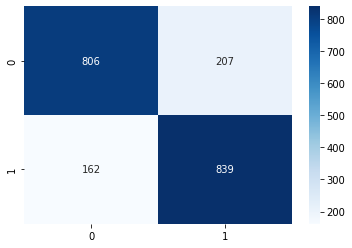

In [ ]:
crossValEvaluate(svm_clf, X_train, y_train)

Test Accuracy: 0.6852248394004282
Precision: 0.6708860759493671
Recall: 0.6973684210526315


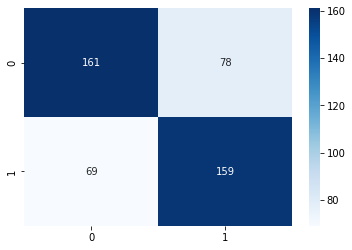

In [ ]:
testSetEvaluate(svm_clf, X_train, y_train, X_test, y_test)

#### Polynomial SVM

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='poly', C=1, probability=True)

Validation Accuracy: 0.8862959285004965
Precision: 0.876953125
Recall: 0.8971028971028971


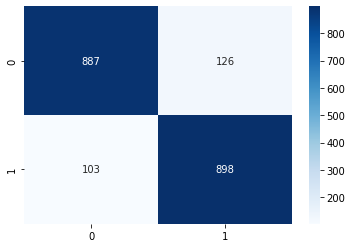

In [ ]:
crossValEvaluate(svm_clf, X_train, y_train)

Test Accuracy: 0.7708779443254818
Precision: 0.7489711934156379
Recall: 0.7982456140350878


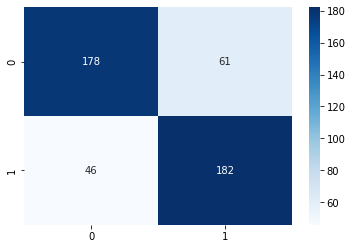

In [ ]:
testSetEvaluate(svm_clf, X_train, y_train, X_test, y_test)

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree_clf = DecisionTreeClassifier(max_depth=8, max_features=20)

Validation Accuracy: 0.7994041708043694
Precision: 0.7686768676867687
Recall: 0.8531468531468531


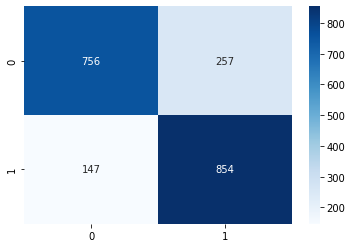

In [ ]:
crossValEvaluate(dtree_clf, X_train, y_train)

Test Accuracy: 0.7323340471092077
Precision: 0.7309417040358744
Recall: 0.7149122807017544


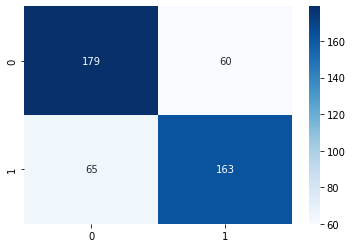

In [ ]:
testSetEvaluate(dtree_clf, X_train, y_train, X_test, y_test)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=24, max_depth=6)

Validation Accuracy: 0.8922542204568024
Precision: 0.8512544802867383
Recall: 0.949050949050949


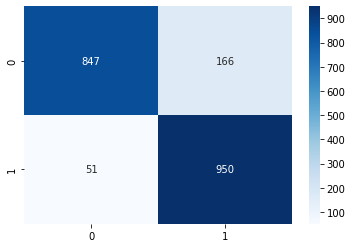

In [ ]:
crossValEvaluate(rf_clf, X_train, y_train)

Test Accuracy: 0.8265524625267666
Precision: 0.8266666666666667
Recall: 0.8157894736842105


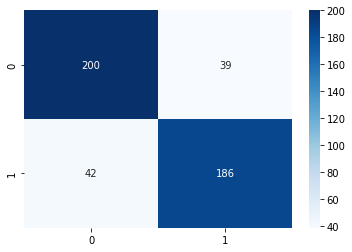

In [ ]:
testSetEvaluate(rf_clf, X_train, y_train, X_test, y_test)

### Ensemble - Voting Classifier
Combining all the above models into a voting classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
                ('log', log_clf),
                ('svm', svm_clf),
                ('dtree', dtree_clf),
                ('rf', rf_clf)
    ],
    weights=[0.75, 0.85, 0.85, 0.9],
    voting='soft'
)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Test Accuracy: 0.7922912205567452
Precision: 0.788546255506608
Recall: 0.7850877192982456


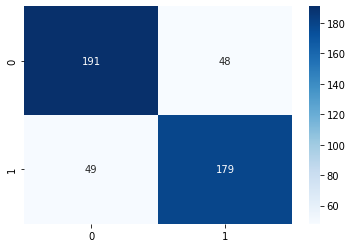

In [ ]:
testSetEvaluate(voting_clf, X_train, y_train, X_test, y_test)

###Inference:
- Logistic Regression: 70.02%
- Linear SVM: 68.52%
- Poly SVM: 77.08%
- Decision Tree: 73.23%
- Random Forest: 82.65%
- Voting Classifier: 79.22%

## Neural Network

We create a validation set to validate the neural network after every epoch.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
from keras.applications.densenet import DenseNet201
from keras.layers import GlobalAveragePooling2D

In [ ]:
def build_nn_model():
    densenet201 = DenseNet201(weights='imagenet', include_top=False)

    input = Input(shape=(64, 64, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet201(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(1,activation = 'sigmoid', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
nn_model = build_nn_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 densenet201 (Functional)    (None, None, None, 1920)  18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1920)              0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


We define two callback functions to assist the training process.
- Annealer: To reduce learning rate when the accuracy does not change for 5 continuous epochs
- Checkpoint: Saves the best model after every epoch

We also perform data augmentation such as shifting, rotating and zooming inorder to increase the training data

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('CovidClassifier.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

In [ ]:
BATCH_SIZE=32
EPOCHS=10

In [ ]:
hist = nn_model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, y_val))

Epoch 1/10

Epoch 00001: val_loss improved from 0.72319 to 0.64316, saving model to MobileNetV2.h5
50/50 - 197s - loss: 0.8135 - accuracy: 0.6080 - val_loss: 0.6432 - val_accuracy: 0.6352 - lr: 0.0020 - 197s/epoch - 4s/step
Epoch 2/10

Epoch 00002: val_loss did not improve from 0.64316
50/50 - 192s - loss: 0.7289 - accuracy: 0.6548 - val_loss: 0.8436 - val_accuracy: 0.5806 - lr: 0.0020 - 192s/epoch - 4s/step
Epoch 3/10

Epoch 00003: val_loss improved from 0.64316 to 0.64042, saving model to MobileNetV2.h5
50/50 - 194s - loss: 0.6686 - accuracy: 0.6890 - val_loss: 0.6404 - val_accuracy: 0.6600 - lr: 0.0020 - 194s/epoch - 4s/step
Epoch 4/10

Epoch 00004: val_loss did not improve from 0.64042
50/50 - 198s - loss: 0.6155 - accuracy: 0.7327 - val_loss: 0.6978 - val_accuracy: 0.6625 - lr: 0.0020 - 198s/epoch - 4s/step
Epoch 5/10

Epoch 00005: val_loss improved from 0.64042 to 0.51735, saving model to MobileNetV2.h5
50/50 - 195s - loss: 0.5733 - accuracy: 0.7378 - val_loss: 0.5173 - val_accur

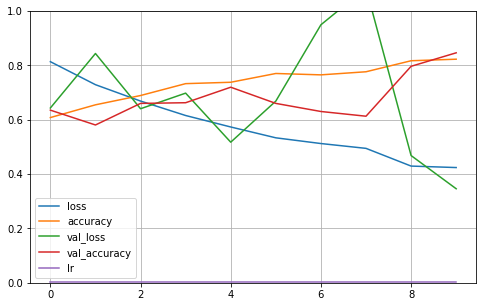

In [ ]:
pd.DataFrame(hist.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

As more epochs are given to the model, the accuracy is going up and the loss gets minimized

In [ ]:
nn_model.evaluate(X_test, y_test, batch_size=64)

8/8 [==============================] - 9s 1s/step - loss: 0.4875 - accuracy: 0.8351


[0.48750367760658264, 0.835117757320404]

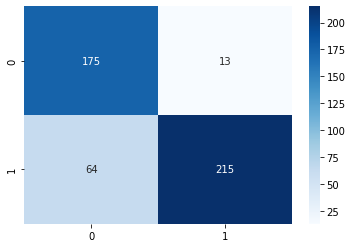

In [ ]:
y_proba = nn_model.predict(X_test)
y_pred = (y_proba > 0.5).astype('int64')
plotConfusionMatrix(y_pred, y_test)